# Nonlinear Regression

Relatively advanced problems in optimization...nonlinear regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.integrate import solve_ivp

## Nonlinear Least Squares Recap:

We should have a feel for how useful least squares analysis can be at this point.  We've done this quite a bit using both linear and nonlinear least squares to find rate laws and/or kinetic parameters (rate constants, activation barriers, etc.).

The main problem with kinetic analysis is that, although we usually have a single equation that describes the performance of our reactor, like the solution below for a first order reaction in a constant volume batch reactor:

$$C_A = C_{A0}e^{-kt}$$

We always have 10 or 20 or 50 data points to work with.  That means we would like to satisfy the above equation at all of those data points...but we can't!  Experimental errors mean that there is no unique solution to this problem.  Instead, we have to find the *best* values of the parameters of interest.  In our context, the *best* value is the one that minimizes the total sum of square errors between our measurement and our model's prediction.

$$SSE = \sum_k(y_k - \hat{y}_k)^2$$

Knowing how to solve least squares problems is extremely useful.  This is basically how we approach trying to find the "best" value of a variable parameter in all sorts of models.  No matter what problem you are trying to solve, the method behind nonlinear least squares is always the same:

1. Propose a model that includes your variable parameters (e.g., a rate constant or reaction order)
2. Use that model to calculate the value of your measurable quantity at each experimental condition (e.g., a concentration at a specific time)
3. Calculate the square error between your measurement and the value predicted by your model
4. Sum the square errors for each data point.
5. Use an iterative solver to vary the parameters of interest until the sum of square errors is at a minimum.

Learn these principles, and learn how to apply them.  You will find them useful in numerous situations.  We'll apply them to kinetic analysis today, but they are extremely, extremely useful!!!

<div class = "alert alert-block alert-info">
    <b>Note</b>: Although Linear regression methods are extremely useful and often preferential, sometimes it is not possible to linearize a problem, so we will use today's recitation to get some extra practice with nonlinear regression today, and we will specifically avoid using linear algebra solutions.
    <div>

## Example Problem 01

We want to determine the rate constant for the following reaction:

$$A \longrightarrow B$$

For this experiment, we use a constant volume batch reactor, and we know a few things about the reaction.  First, the rate of reaction is first order in species A.  Second, the rate is independent of the concentration of B. Based on the above, we write the following rate law:

$$r = kC_A$$

Finally, the concentration of A at the start of the experiment was quantified very precisely.  We know that it is equal to 15 moles per liter.  Then:

$$C_{A0} = 15 \ \textrm{mol} \ \textrm{L}^{-1}$$

Otherwise, the only information that we have is that we measured the concentration of the reactant (A) as it disappears over time in the reactor.  The data is compiled in a separate CSV files, t1 and C1, which we will learn how to load and convert to a numpy array in the cell below.  Times are in minutes, and concentrations are in mol/L.

In [2]:
import csv

#Load Experimental Times; convert to 1D numpy array
file = open("t1.csv") #experimental times in minutes
csvreader = csv.reader(file)
rows = []
for row in csvreader:
     rows.append(row)
file.close()
print(np.array(rows, dtype = 'float').shape)
t1 = np.array(rows, dtype = 'float').reshape(len(rows), )
print(t1.shape)

#Load Experimental Concentrations; convert to 1D numpy array
file = open("C1.csv")
csvreader = csv.reader(file)
rows = []
for row in csvreader:
     rows.append(row)
file.close()
print(np.array(rows, dtype = 'float').shape)
C1 = np.array(rows, dtype = 'float').reshape(len(rows), )
print(C1.shape)

FileNotFoundError: [Errno 2] No such file or directory: 't1.csv'

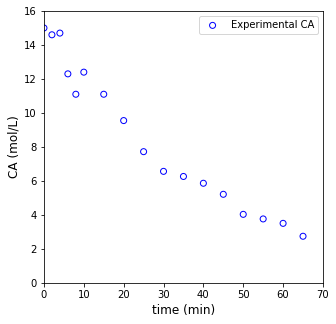

In [3]:
#Plot Data
plt.figure(1, figsize = (5, 5))
plt.scatter(t1, C1, marker = 'o', color = 'none', edgecolor = 'blue', label = 'Experimental CA')
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('CA (mol/L)', fontsize = 12)
plt.xlim(0, 70)
plt.ylim(0, 16)
plt.legend()
plt.show()

### Material Balance on the Batch Reactor

We know that this is a first order reaction in a constant volume batch reactor.  An appropriate material balance to model this system is:

$$\frac{dC_A}{dt} = -kC_A$$

And we know how to solve this analytically to get:

$$C_A = C_{A0}\exp(-kt)$$

So we have a nonlinear model.  We can overlay that model with a guess at the rate constant and see how well it agrees with our data.

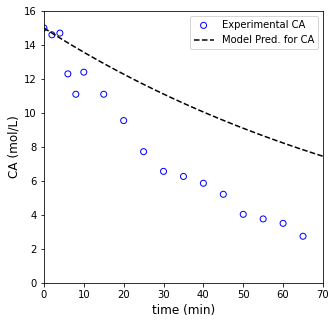

In [4]:
CA0   = 15.0  #mol/L
k     = 0.01  #1/min
tmod  = np.linspace(0, 70, 100)
CAmod = CA0*np.exp(-k*tmod) 

plt.figure(1, figsize = (5, 5))
plt.scatter(t1, C1, marker = 'o', color = 'none', edgecolor = 'blue', label = 'Experimental CA')
plt.plot(tmod, CAmod, label = 'Model Pred. for CA', color = 'black', linestyle = 'dashed')
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('CA (mol/L)', fontsize = 12)
plt.xlim(0, 70)
plt.ylim(0, 16)
plt.legend()
plt.show()

### Using an optimization routine

As usual, we can do much better by creating an objective function and minimizing it with an optimization routine.  Here, we'll create an objective function that calculates our sum of squares as a function of our variable parameter (the rate constant), and we'll use opt.minimize_scaler to find the "best" value of the rate constant, i.e., the one that minimizes the error between our model predictions and our measurments.

In [5]:
def obj1(par):
    k     = par 
    texp  = t1 
    CAexp = C1 
    
    CA0   = 15.0  #mol/L
    CAmod = CA0*np.exp(-k*texp)  #mol/L
    
    SSE = np.sum(((CAexp - CAmod))**2) 
    return SSE

ans1  = opt.minimize_scalar(obj1, method = 'Brent', bracket = [0.001, 1])
k_opt = ans1.x
SSE   = ans1.fun
print(ans1, '\n')
print(f'The optimum rate constant is {k_opt:3.3f} 1/min with a SSE value of {SSE}')

     fun: 5.219517433217731
 message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
    nfev: 23
     nit: 19
 success: True
       x: 0.024798795778781392 

The optimum rate constant is 0.025 1/min with a SSE value of 5.219517433217731


Now that we know the optimum value of the rate constant, we can overlay the model with our measurments and see how well it does.  It is good to get in the habit of looking at the raw residual error as it gives you an idea of whether your measurements are randomly scattered about the best fit line, or if there is systematic deviation.  We'll calculate that quanity and plot it as a function of each measurement's concentration.

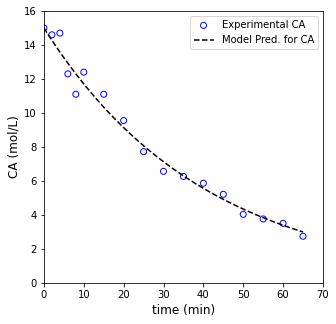

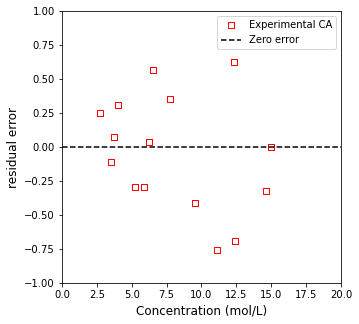

In [6]:
CA0   = 15.0  #mol/L
k     = 1  #1/min
tmod  = np.linspace(0, max(t1), 100)
CAmod = CA0*np.exp(-k_opt*tmod)
resid = CA0*np.exp(-k_opt*t1) - C1

#overlay best fit model with measurements

plt.figure(1, figsize = (5, 5))
plt.scatter(t1, C1, marker = 'o', color = 'none', edgecolor = 'blue', label = 'Experimental CA')
plt.plot(tmod, CAmod, label = 'Model Pred. for CA', color = 'black', linestyle = 'dashed')
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('CA (mol/L)', fontsize = 12)
plt.xlim(0, 70)
plt.ylim(0, 16)
plt.legend()
plt.show()

#plot residual errors
plt.figure(2, figsize = (5, 5))
plt.scatter(C1, resid, marker = 's', color = 'none', edgecolor = 'red', label = 'Experimental CA')
plt.hlines(0, 0, 20, color = 'black', linestyle = 'dashed', label = 'Zero error')
plt.xlim(0, 20)
plt.ylim(-1, 1)
plt.xlabel('Concentration (mol/L)', fontsize = 12)
plt.ylabel('residual error', fontsize = 12)
plt.legend()
plt.show()

## Example Problem 02

The two following reactions occur in a constant volume batch reactor:

\begin{align}
    2A + B \longrightarrow C \\
    B  + 2C \longrightarrow D \\
\end{align}

Both reactions follow an elementary rate law; however, we do not know either of the rate constants (k$_1$ and k$_2$), so we attempt to estimate them from data collected in our constant volume batch reactor.  The data (time in minutes and concentrations of A, B, C, and D in moles per liter) are included in the CSV files t2 and C2.

The initial concentrations of species A and B are 25 and 20 moles per liter, respectively.  The initial concentrations of C and D are both zero.

In [7]:
#Load Experimental Times; convert to 1D numpy array
file = open("t2.csv")
csvreader = csv.reader(file)
rows = []
for row in csvreader:
     rows.append(row)
file.close()
t2 = np.array(rows, dtype = 'float').reshape(len(rows),)

#Load Experimental Concentrations; convert to 1D numpy array
file = open("C2.csv")
csvreader = csv.reader(file)
rows = []
for row in csvreader:
     rows.append(row)
file.close()
C2 = np.array(rows, dtype = 'float')

### Visualize the data

Plot the data to get a feel for what we're working with.

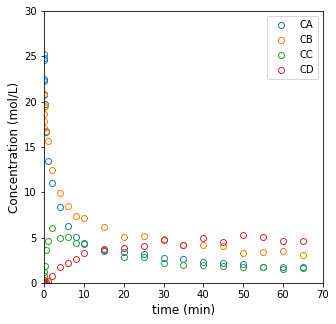

In [8]:
plt.figure(1, figsize = (5, 5))
plt.plot(t2, C2, marker = 'o', markerfacecolor = 'none', linestyle = 'none')
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('Concentration (mol/L)', fontsize = 12)
plt.xlim(0, 70)
plt.ylim(0, 30)
plt.legend(['CA', 'CB', 'CC', 'CD'])
plt.show()

### Setting up the Least Squares Problem

When we move toward the least squares analysis, we run into an issue: we can't solve this reactor model analytically as we would with a normal "integral analysis" method.  We have to integrate it numerically.  This gets a little more tricky in terms of the code.  First, let's just remember how we would solve this problem in general by solving a constant volume batch reactor for values of k1 and k2 that we will just guess.

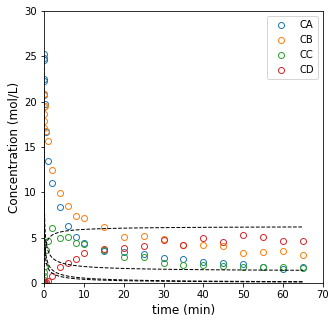

In [9]:
def P2a(t, var):
    CA = var[0]
    CB = var[1]
    CC = var[2]
    CD = var[3]
    
    k1 = 0.05
    k2 = 0.05
    
    r1 = k1*CA**2*CB
    r2 = k2*CB*CC**2
    
    RA = -2*r1
    RB = -1*r1 - 1*r2
    RC =  1*r1 - 2*r2
    RD =  0*r1 + 1*r2
    
    D1 = RA
    D2 = RB
    D3 = RC
    D4 = RD
    return [D1, D2, D3, D4]

C0     = [25, 20, 0, 0] #mol/L
tspan  = (0, max(t2))
ans2a  = solve_ivp(P2a, tspan, C0, atol = 1e-8, rtol = 1e-8)

plt.figure(1, figsize = (5, 5))
plt.plot(t2, C2, marker = 'o', markerfacecolor = 'none', linestyle = 'none')
plt.plot(ans2a.t, ans2a.y.T, color = 'black', linestyle = 'dashed', linewidth = 1)
#plt.semilogx(t2, C2, marker = 'o', markerfacecolor = 'none', linestyle = 'none')
#plt.semilogx(ans2a.t, ans2a.y.T, color = 'black', linestyle = 'dashed', linewidth = 1)
plt.xlabel('time (min)', fontsize = 12)
plt.ylabel('Concentration (mol/L)', fontsize = 12)
plt.xlim(0, 70)
plt.ylim(0, 30)
plt.legend(['CA', 'CB', 'CC', 'CD'])
plt.show()

### Create a more flexible ODE function that allows us to pass parameters

But we have to be thinking more flexibly.  We need to not be setting the rate constants ourselves, but allowing an optimization routine to iteratively vary them.  We'll work through this in a couple of steps.  First, let's convert our ODE system for the batch reactor so that it will accept parameters as arguments; this will make it much easier for us to set their values to try new combinations.

C:\Users\jqbond\AppData\Local\Temp\ipykernel_15324\1348585146.py:35: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 70)


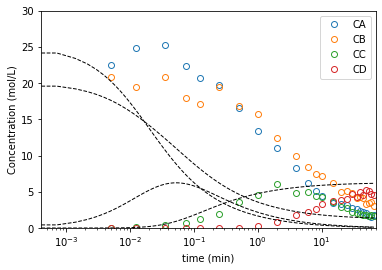

In [10]:
def P2b(t, var, par):
    CA = var[0]
    CB = var[1]
    CC = var[2]
    CD = var[3]
    
    k1 = par[0]
    k2 = par[1]
    
    r1 = k1*CA**2*CB
    r2 = k2*CB*CC**2
    
    RA = -2*r1
    RB = -1*r1 - 1*r2
    RC =  1*r1 - 2*r2
    RD =  0*r1 + 1*r2
    
    D1 = RA
    D2 = RB
    D3 = RC
    D4 = RD
    return [D1, D2, D3, D4]

C0     = [25, 20, 0, 0] #mol/L
tspan  = (0, max(t2))
par    = [0.05, 0.05]
ans2b  = solve_ivp(P2b, tspan, C0, args = (par, ), atol = 1e-8, rtol = 1e-8)

#plt.plot(t2, C2, marker = 'o', markerfacecolor = 'none', linestyle = 'none')
#plt.plot(ans2b.t, ans2b.y.T, color = 'black', linestyle = 'dashed', linewidth = 1)
plt.semilogx(t2, C2, marker = 'o', markerfacecolor = 'none', linestyle = 'none')
plt.semilogx(ans2b.t, ans2b.y.T, color = 'black', linestyle = 'dashed', linewidth = 1)
plt.xlabel('time (min)')
plt.ylabel('Concentration (mol/L)')
plt.xlim(0, 70)
plt.ylim(0, 30)
plt.legend(['CA', 'CB', 'CC', 'CD'])
plt.show()

### Use the ODE solver to evaluate your objective function

Now, we can use that model along with the ODE solver to calculate the residual sum of squares between the model and measurments.  We'll do this first as a demo, and then we'll convert it into an objective function

In [11]:
texp   = t2
Cexp   = C2
C0     = [25, 20, 0, 0] #mol/L
tspan  = (0, max(t2))

par0    = [0.05, 0.05]
ans2c   = solve_ivp(P2b, tspan, C0, args = (par0, ), atol = 1e-8, rtol = 1e-8, t_eval = texp)
Cmod    = ans2c.y.T
#print(Cexp)
#print(Cmod)

SQERROR = ((Cexp - Cmod))**2
print(SQERROR.shape)
print(SQERROR.flatten().shape)
SSE     = np.sum(SQERROR.flatten())
print(SSE)

(25, 4)
(100,)
3071.831104707376


Now that we have an understanding of how we could use a numerical solution to generate model predictions at various experimental times, we can embed this in an objective function.

In [12]:
def obj2(par):
    #print(par)
    texp   = t2
    Cexp   = C2
    C0     = [25, 20, 0, 0] #mol/L
    tspan  = (0, max(t2))

    ans2    = solve_ivp(P2b, tspan, C0, args = (par, ), atol = 1e-8, rtol = 1e-8, t_eval = texp)
    Cmod    = ans2.y.T
    
    SQERROR = ((Cexp - Cmod))**2 
    SSE     = np.sum(SQERROR.flatten())
    return SSE

par0  = [0.05, 0.05]
#ans2d = opt.minimize(obj2, par0)
bnds  = ((0, None), (0, None))
ans2d = opt.minimize(obj2, par0, method = 'L-BFGS-B', bounds = bnds)
print(ans2d, '\n')
k1_opt, k2_opt = ans2d.x
par_opt = ans2d.x
SSE   = ans2d.fun
print(f'The optimum rates constant are k1 = {k1_opt:3.3E} and k2 = {k2_opt:3.3E} giving an SSE value of {SSE:3.3f}')

      fun: 33.18150076035588
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.01157687,  0.00423839])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 60
      nit: 9
     njev: 20
   status: 0
  success: True
        x: array([0.00090213, 0.00128056]) 

The optimum rates constant are k1 = 9.021E-04 and k2 = 1.281E-03 giving an SSE value of 33.182


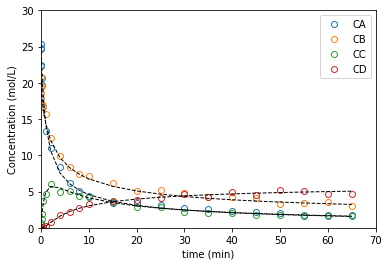

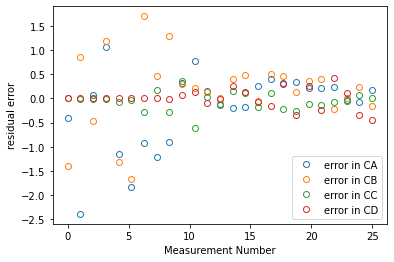

In [13]:
ans2e  = solve_ivp(P2b, tspan, C0, args = (par_opt, ), atol = 1e-8, rtol = 1e-8, t_eval = t2)
resid  = (C2 - ans2e.y.T)
nexp   = len(t2)
expn   = np.linspace(0, nexp, nexp)

plt.figure(1)
plt.plot(t2, C2, marker = 'o', markerfacecolor = 'none', linestyle = 'none')
plt.plot(ans2e.t, ans2e.y.T, color = 'black', linestyle = 'dashed', linewidth = 1)
#plt.semilogx(t2, C2, marker = 'o', markerfacecolor = 'none', linestyle = 'none')
#plt.semilogx(ans2e.t, ans2e.y.T, color = 'black', linestyle = 'dashed', linewidth = 1)
plt.xlabel('time (min)')
plt.ylabel('Concentration (mol/L)')
plt.xlim(0, 70)
plt.ylim(0, 30)
plt.legend(['CA', 'CB', 'CC', 'CD'])

plt.figure(2)
plt.plot(expn, resid, marker = 'o', markerfacecolor = 'none', linestyle = 'none')
plt.xlabel('Measurement Number')
plt.ylabel('residual error')
plt.legend(['error in CA', 'error in CB', 'error in CC', 'error in CD'], loc = 'lower right')
plt.show()

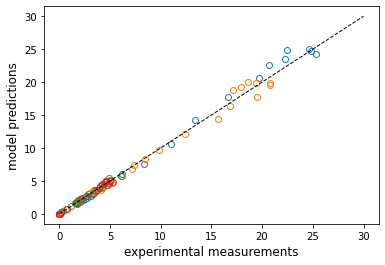

In [14]:
parity = [1e-7, 30]
plt.plot(C2, ans2e.y.T, marker = 'o', markerfacecolor = 'none', linestyle = 'none')
plt.plot(parity, parity, color = 'black', linestyle = 'dashed', linewidth = 1)
#plt.loglog(C2, ans2e.y.T, marker = 'o', markerfacecolor = 'none', linestyle = 'none')
#plt.loglog(parity, parity, color = 'black', linestyle = 'dashed', linewidth = 1)
plt.xlabel('experimental measurements', fontsize = 12)
plt.ylabel('model predictions', fontsize = 12)
plt.show()

<span style="font-family:Times New Roman; font-size:1.5em;">**Problem 3**</span>

Now for an analysis that is actually representative of the type of work we do in our research group.  We will start with a reaction:

$$A + B\longrightarrow C$$

For which we have collected a lot of kinetic data.  Specifically, we have estimated rates of reaction by measuring the effluent flowrate of species C in a differential plug flow reactor having a volume of 1.0L.  For this case study, we measured rates of reaction at various concentrations of A, concentrations of B, and reaction temperature. Eventually, we'll consider the full data set, but for right now, let's just look at data collected at 573K.  This is saved in the DATA1 file included with this worksheet.

Load the rate data obtained at 573K. In this data set, concentrations of A (Column 1) and B (Column 2) are in moles per liter, temperature (Column 3) is in Kelvin, and the rate of reaction (Column 4) is in moles per liter per minute.

Analyze to determine the reaction orders in A and B; propose a rate law that is consistent with this behavior.


In [15]:
#Load Experimental Times; convert to 1D numpy array
file = open("DATA1.csv")
csvreader = csv.reader(file)
rows = []
for row in csvreader:
     rows.append(row)
file.close()
DATA1 = np.array(rows, dtype = 'float')
print(DATA1)
EXP1  = DATA1[0:17, :]
EXP2  = DATA1[17:,:]

CA1  = EXP1[:,0]
CB1  = EXP1[:,1]
T1   = EXP1[:,2]
r1   = EXP1[:,3]

CA2  = EXP2[:,0]
CB2  = EXP2[:,1]
T2   = EXP2[:,2]
r2   = EXP2[:,3]

[[1.00e-04 1.00e-02 5.73e+02 2.34e-04]
 [2.00e-04 1.00e-02 5.73e+02 4.96e-04]
 [5.00e-04 1.00e-02 5.73e+02 1.22e-03]
 [1.00e-03 1.00e-02 5.73e+02 2.08e-03]
 [2.00e-03 1.00e-02 5.73e+02 4.44e-03]
 [5.00e-03 1.00e-02 5.73e+02 8.70e-03]
 [1.00e-02 1.00e-02 5.73e+02 1.18e-02]
 [2.00e-02 1.00e-02 5.73e+02 1.41e-02]
 [5.00e-02 1.00e-02 5.73e+02 1.36e-02]
 [1.00e-01 1.00e-02 5.73e+02 1.04e-02]
 [2.00e-01 1.00e-02 5.73e+02 6.33e-03]
 [5.00e-01 1.00e-02 5.73e+02 3.03e-03]
 [1.00e+00 1.00e-02 5.73e+02 1.49e-03]
 [2.00e+00 1.00e-02 5.73e+02 8.46e-04]
 [5.00e+00 1.00e-02 5.73e+02 2.88e-04]
 [1.00e+01 1.00e-02 5.73e+02 1.73e-04]
 [2.00e+01 1.00e-02 5.73e+02 7.46e-05]
 [1.00e-02 1.00e-04 5.73e+02 1.39e-05]
 [1.00e-02 2.00e-04 5.73e+02 5.93e-05]
 [1.00e-02 5.00e-04 5.73e+02 3.25e-04]
 [1.00e-02 1.00e-03 5.73e+02 9.26e-04]
 [1.00e-02 2.00e-03 5.73e+02 3.01e-03]
 [1.00e-02 5.00e-03 5.73e+02 8.36e-03]
 [1.00e-02 1.00e-02 5.73e+02 1.16e-02]
 [1.00e-02 2.00e-02 5.73e+02 1.89e-02]
 [1.00e-02 5.00e-02 5.73e

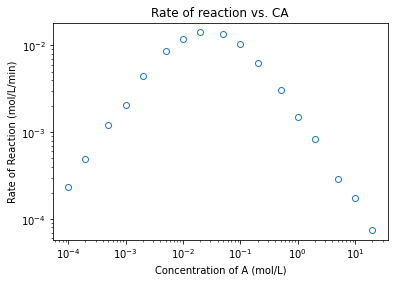

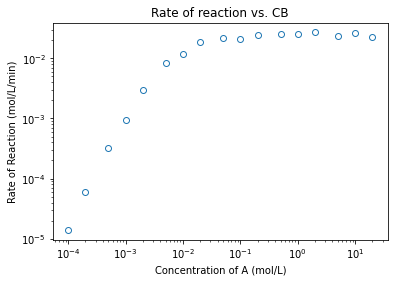

In [16]:
plt.figure(1)
plt.loglog(CA1, r1, marker = 'o', markerfacecolor = 'none', linestyle = 'none')
plt.title('Rate of reaction vs. CA')
plt.xlabel('Concentration of A (mol/L)')
plt.ylabel('Rate of Reaction (mol/L/min)')
plt.show()

plt.figure(2)
plt.loglog(CB2, r2, marker = 'o', markerfacecolor = 'none', linestyle = 'none')
plt.title('Rate of reaction vs. CB')
plt.xlabel('Concentration of A (mol/L)')
plt.ylabel('Rate of Reaction (mol/L/min)')
plt.show()

In [17]:
coeffs1low  = np.polyfit(np.log(CA1[0:3]), np.log(r1[0:3]), 1)
coeffs2low  = np.polyfit(np.log(CB2[0:3]), np.log(r2[0:3]), 1)
coeffs1high = np.polyfit(np.log(CA1[-4:]), np.log(r1[-4:]), 1)
coeffs2high = np.polyfit(np.log(CB2[-4:]), np.log(r2[-4:]), 1)

a_low  = coeffs1low[0]
a_high = coeffs1high[0]
b_low  = coeffs2low[0]
b_high = coeffs2high[0]

print(a_low, a_high, '\n')
print(b_low, b_high)

1.0237136126712598 -1.0282325289457848 

1.9530865324665705 -0.0465220400894623


<span style="font-family:Times New Roman; font-size:1.5em;">**Problem 4**</span>

We propose this rate law describes the kinetcs observed:

$$r = \frac{kC_A{C_B}^2}{(1 + K_AC_A + K_BC_B)^2}$$

Now that we've established a plausible rate law that describes these kinetics, we can try to regress our parameters using least squares.  Our steps, as always:

1. We propose a model
2. We use that model to calculate a prediction at every experimental condition
3. We calculate the error (residual, square error) between prediction and measurement
4. We make a good guess as to the initial values of our parameters
5. We use an iterative algorithm to minimize the sum of square error by varying those parameters.

To help stabilize our parameter estimation, we will assume we know the Arrhenius pre-exponential factor:

$$A = 1\times 10^{18} \ \textrm{L}^{2} \ \textrm{mol}^{-2} \ \textrm{min}^{-1}$$

We will use this pre-factor to calculate a rate constant:

$$k = Ae^{\frac{-EA}{RT}}$$

Let's start just by building the model and using a set of parameter values that we guess and see how it compares to our experimental measurements.  Once we do that, we can use that model to construct an objective function, and then we'll estimate all three parameters that we need to solve this rate law.

In [18]:
def temp4(par):

    EXPDATA = DATA1
    CA   = EXPDATA[:,0]
    CB   = EXPDATA[:,1]
    T    = EXPDATA[:,2]
    rexp = EXPDATA[:,3]
    
    EA = par[0]
    k  = 1e18*np.exp(-EA/8.314/T);
    KA = par[1]
    KB = par[2]
    
    rmod  = k*CA*CB**2/(1 + KA*CA + KB*CB)**2
    resid = (rexp - rmod)/rexp
    SSE   = sum(resid**2)
    return [SSE, rmod, rexp, resid]

EA = 95494 J/mol, KA = 11136 L/mol, KB = 28287 L/mol


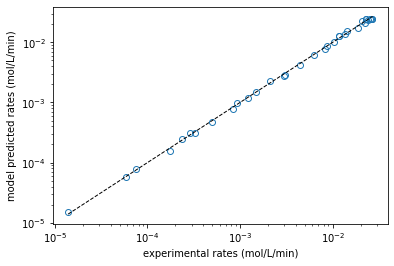

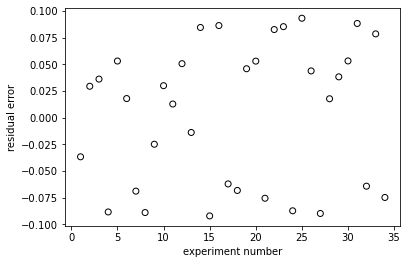

In [19]:
par0 = [100000, 10000, 30000] 
obj4 = lambda par: temp4(par)[0]
ans4 = opt.minimize(obj4, par0)
EA, KA, KB = ans4.x
SSE, rmod, rexp, resid = temp4(ans4.x)

print(f'EA = {EA:5.0f} J/mol, KA = {KA:5.0f} L/mol, KB = {KB:5.0f} L/mol')

plt.figure(1)
plt.loglog(rexp, rmod, marker = 'o', markerfacecolor = 'none', linestyle = 'none')
plt.loglog([min(rexp), max(rexp)], [min(rexp), max(rexp)], color = 'black', linestyle = 'dashed', linewidth = 1)
plt.xlabel('experimental rates (mol/L/min)')
plt.ylabel('model predicted rates (mol/L/min)')
plt.show()

plt.figure(2)
plt.scatter(np.linspace(1, len(rexp), len(rexp)), resid, marker = 'o', color = 'none', edgecolor = 'black')
plt.xlabel('experiment number')
plt.ylabel('residual error')
plt.show()

<span style="font-family:Times New Roman; font-size:1.5em;">**Problem 5**</span>

Now let's see if we can do this for the whole data set, where temperatures are actually changing.  We know that equilibrium constants change with temperature, so we cannot use a single, fixed value for KA and KB anymore.  Instead, we have to use a model to describe how they change with temperature.  Here, I'll use a van't Hoff equation, where their values are referenced to the equilibrium constant calculated at the mean reaction temperature.

$$K_i = K_{im}e^{\frac{-\Delta H_i}{RT}\left(\frac{1}{T}-\frac{1}{T_m}\right)}$$

In [23]:
#Load Experimental Times; convert to 1D numpy array
file = open("DATA2.csv")
csvreader = csv.reader(file)
rows = []
for row in csvreader:
     rows.append(row)
file.close()
DATA2 = np.array(rows, dtype = 'float')
DATA2;

In [21]:
def temp5(par):

    EXPDATA = DATA2
    CA   = EXPDATA[:,0]
    CB   = EXPDATA[:,1]
    T    = EXPDATA[:,2]
    rexp = EXPDATA[:,3]
    
    A   = 1e18
    EA  = par[0]
    KA0 = par[1]
    DHA = par[2]
    KB0 = par[3]
    DHB = par[4]
    Tm  = np.mean(T)
    R   = 8.314
    
    k   = A*np.exp(-EA/R/T)
    KA  = KA0*np.exp(-DHA/R*(1/T - 1/Tm))
    KB  = KB0*np.exp(-DHB/R*(1/T - 1/Tm))
    rmod   = k*CA*CB**2/(1 + KA*CA + KB*CB)**2
    resid = (rmod - rexp)/rexp
    SSE   = sum(resid**2);
    return [SSE, rmod, rexp, resid]

EA = 96301 J/mol, KA0 =   710 L/mol, DHA = -109925 J/mol, KB0 =  2128 L/mol, DHB = -102805 J/mol


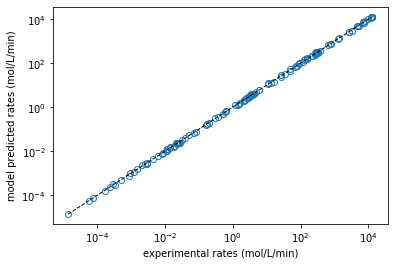

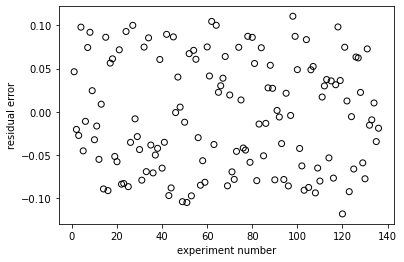

In [22]:
par0 = [100000, 1000, -100000, 1000, -100000]
obj5 = lambda par: temp5(par)[0]
ans5 = opt.minimize(obj5, par0)
EA, KA0, DHA, KB0, DHB = ans5.x
SSE, rmod, rexp, resid = temp5(ans5.x)

print(f'EA = {EA:5.0f} J/mol, KA0 = {KA0:5.0f} L/mol, DHA = {DHA:5.0f} J/mol, KB0 = {KB0:5.0f} L/mol, DHB = {DHB:5.0f} J/mol')

plt.figure(1)
plt.loglog(rexp, rmod, marker = 'o', markerfacecolor = 'none', linestyle = 'none')
plt.loglog([min(rexp), max(rexp)], [min(rexp), max(rexp)], color = 'black', linestyle = 'dashed', linewidth = 1)
plt.xlabel('experimental rates (mol/L/min)')
plt.ylabel('model predicted rates (mol/L/min)')
plt.show()

plt.figure(2)
plt.scatter(np.linspace(1, len(rexp), len(rexp)), resid, marker = 'o', color = 'none', edgecolor = 'black')
plt.xlabel('experiment number')
plt.ylabel('residual error')
plt.show()